# Time Series Forecasting using XGBoost

Let's first import all the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's import the csv file containing historical of energy demand in the UK data from 2009 to 2023

In [3]:
df = pd.read_csv('historic_demand_2009_2023_noNaN.csv')

In [4]:
df.head(5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


Set the DataFrame index as the date

In [5]:
df.set_index('settlement_date',inplace=True)
df.head(5)

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


Let's plot the Total System Demand (TSD) in MW during the entire dataset

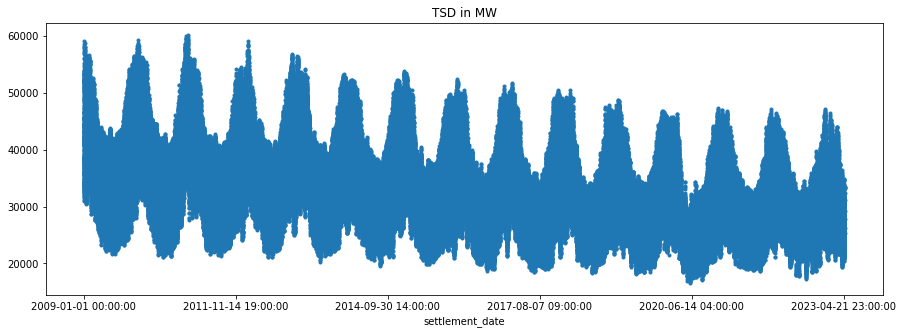

In [6]:
df['tsd'].plot(style='.',figsize=(15,5),title='TSD in MW')

Convert the index column to a datetime object

In [7]:
df.index = pd.to_datetime(df.index)

# Train / Test Split

Let's split our dataset into a training and testing sets. We used data from 2009 to 2022 as the training samples and data corresponding to year 2023 as the test set.

In [8]:
train = df.loc[df.index < '01-01-2023']
test = df.loc[df.index >= '01-01-2023']

Let's visualize both sets in a single plot. The vertical dotted line marks the train/test split date

C:\Users\israel\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


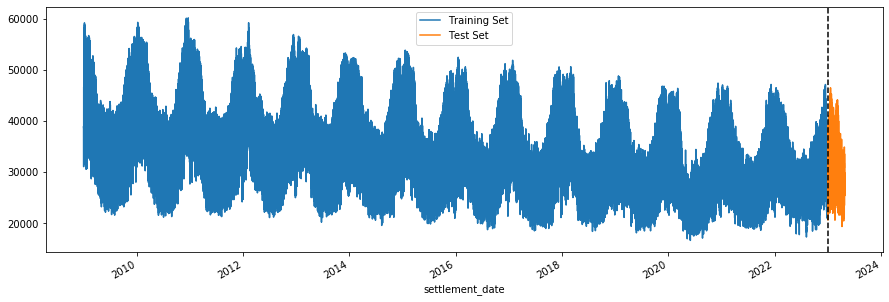

In [9]:
fig,ax = plt.subplots(figsize=(15,5))
train['tsd'].plot(ax=ax,label='Training Set')
test['tsd'].plot(ax=ax,label='Test Set')
ax.axvline('01-01-2023',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

Let's zoom in to better visualize the energy demand behavior during a single week  

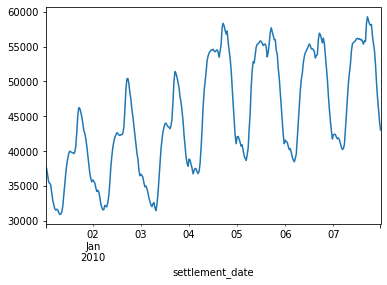

In [10]:
df['tsd'].loc[(df.index>'01-01-2010') & (df.index < '01-08-2010')].plot()

# Feature Creation

From the previous graph we can see peaks in energy consumption corresponding to nightime. Let's use this information to create new features from the datetime column.  

In [11]:
def create_reg_feat(df):
    df = df.copy()
    df['hour']=df.index.hour
    df['dayofweek']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['month']=df.index.month
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    return df

In [12]:
df = create_reg_feat(df)

# Feature Visualization

We can now use seaborn to visualize the behaviour of energy consumption by hour and by month. The daily trend shows to peaks around midday and in the evening. 

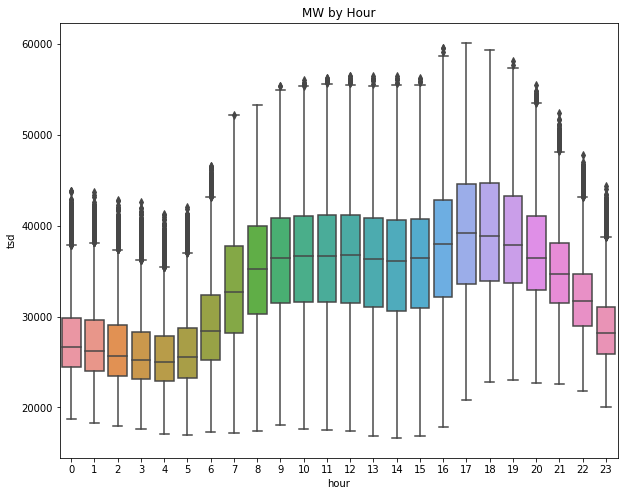

In [13]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='hour',y='tsd')
ax.set_title('MW by Hour')
plt.show()

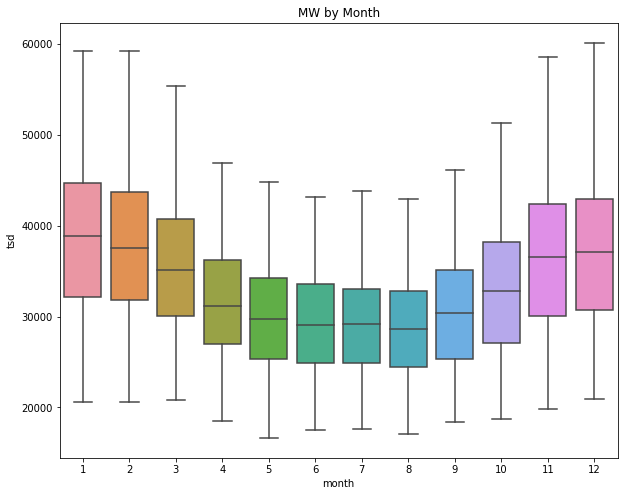

In [14]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='tsd')
ax.set_title('MW by Month')
plt.show()

The yearly trend shows and increased energy consumption during winter months from November to February.

Let's separate the training and testing data with the corresponding features and target variable.

In [15]:
features = ['hour','dayofweek', 'quarter', 'month', 'year', 'dayofyear']
target = 'tsd'

In [16]:
train = create_reg_feat(train)
test = create_reg_feat(test)

In [17]:
X_train = train[features]
y_train = train[target]

In [18]:
X_test = test[features]
y_test = test[target]

# XGB Model Creation

Let's import our XGBoost and lightGBM libraries. We also imported the mean squared error from sklearn to measure each model performance

In [19]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [36]:
model_xgb = xgb.XGBRegressor(n_estimators=1500)

model_xgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=True)

[0]	validation_0-rmse:24056.73047	validation_1-rmse:21424.11523
[1]	validation_0-rmse:16985.08984	validation_1-rmse:14612.17481
[2]	validation_0-rmse:12055.94238	validation_1-rmse:10165.05664
[3]	validation_0-rmse:8642.88672	validation_1-rmse:6995.53955
[4]	validation_0-rmse:6308.38428	validation_1-rmse:5099.61865
[5]	validation_0-rmse:4718.32471	validation_1-rmse:3768.02319
[6]	validation_0-rmse:3657.93213	validation_1-rmse:3133.67139
[7]	validation_0-rmse:2954.65332	validation_1-rmse:2811.43262
[8]	validation_0-rmse:2525.09448	validation_1-rmse:2697.13037
[9]	validation_0-rmse:2241.11304	validation_1-rmse:2680.74829
[10]	validation_0-rmse:2079.25488	validation_1-rmse:2695.21753
[11]	validation_0-rmse:1971.14600	validation_1-rmse:2725.98779
[12]	validation_0-rmse:1906.83386	validation_1-rmse:2760.29028
[13]	validation_0-rmse:1851.78723	validation_1-rmse:2767.64844
[14]	validation_0-rmse:1817.34595	validation_1-rmse:2776.52319
[15]	validation_0-rmse:1787.00610	validation_1-rmse:2784.28

[130]	validation_0-rmse:1156.94226	validation_1-rmse:2830.50659
[131]	validation_0-rmse:1153.51856	validation_1-rmse:2832.48047
[132]	validation_0-rmse:1151.45996	validation_1-rmse:2832.23144
[133]	validation_0-rmse:1149.52978	validation_1-rmse:2832.63037
[134]	validation_0-rmse:1147.22107	validation_1-rmse:2825.79932
[135]	validation_0-rmse:1144.41040	validation_1-rmse:2826.01538
[136]	validation_0-rmse:1142.85278	validation_1-rmse:2826.23511
[137]	validation_0-rmse:1141.02246	validation_1-rmse:2828.80591
[138]	validation_0-rmse:1138.29651	validation_1-rmse:2827.60205
[139]	validation_0-rmse:1136.10840	validation_1-rmse:2825.68506
[140]	validation_0-rmse:1135.01868	validation_1-rmse:2822.85742
[141]	validation_0-rmse:1132.66223	validation_1-rmse:2828.56543
[142]	validation_0-rmse:1131.69019	validation_1-rmse:2833.58789
[143]	validation_0-rmse:1130.18030	validation_1-rmse:2833.48267
[144]	validation_0-rmse:1128.51733	validation_1-rmse:2832.33960
[145]	validation_0-rmse:1125.86023	valid

[259]	validation_0-rmse:978.50330	validation_1-rmse:2888.17529
[260]	validation_0-rmse:977.26031	validation_1-rmse:2891.23706
[261]	validation_0-rmse:975.63867	validation_1-rmse:2893.75732
[262]	validation_0-rmse:974.64307	validation_1-rmse:2893.21338
[263]	validation_0-rmse:973.51221	validation_1-rmse:2897.66187
[264]	validation_0-rmse:972.62836	validation_1-rmse:2898.99438
[265]	validation_0-rmse:970.75909	validation_1-rmse:2898.99438
[266]	validation_0-rmse:969.57929	validation_1-rmse:2901.23169
[267]	validation_0-rmse:968.75995	validation_1-rmse:2905.55884
[268]	validation_0-rmse:968.04712	validation_1-rmse:2907.29858
[269]	validation_0-rmse:966.39130	validation_1-rmse:2910.24023
[270]	validation_0-rmse:965.56213	validation_1-rmse:2912.32080
[271]	validation_0-rmse:964.83441	validation_1-rmse:2911.92334
[272]	validation_0-rmse:964.22144	validation_1-rmse:2912.47070
[273]	validation_0-rmse:963.32770	validation_1-rmse:2912.30762
[274]	validation_0-rmse:962.66962	validation_1-rmse:291

[390]	validation_0-rmse:884.94196	validation_1-rmse:2923.16016
[391]	validation_0-rmse:884.37323	validation_1-rmse:2922.99316
[392]	validation_0-rmse:883.61639	validation_1-rmse:2922.97681
[393]	validation_0-rmse:883.16248	validation_1-rmse:2922.95337
[394]	validation_0-rmse:882.66699	validation_1-rmse:2923.35303
[395]	validation_0-rmse:882.14014	validation_1-rmse:2923.42529
[396]	validation_0-rmse:881.56189	validation_1-rmse:2923.24438
[397]	validation_0-rmse:881.27387	validation_1-rmse:2922.99585
[398]	validation_0-rmse:880.75500	validation_1-rmse:2924.40820
[399]	validation_0-rmse:880.22082	validation_1-rmse:2925.51587
[400]	validation_0-rmse:879.63104	validation_1-rmse:2930.71582
[401]	validation_0-rmse:878.98090	validation_1-rmse:2930.87280
[402]	validation_0-rmse:878.67969	validation_1-rmse:2930.20508
[403]	validation_0-rmse:878.11963	validation_1-rmse:2930.91138
[404]	validation_0-rmse:877.52734	validation_1-rmse:2931.26538
[405]	validation_0-rmse:876.70264	validation_1-rmse:293

[521]	validation_0-rmse:826.96008	validation_1-rmse:2930.26001
[522]	validation_0-rmse:826.66077	validation_1-rmse:2930.21289
[523]	validation_0-rmse:825.97705	validation_1-rmse:2929.03149
[524]	validation_0-rmse:825.57989	validation_1-rmse:2929.49780
[525]	validation_0-rmse:825.17828	validation_1-rmse:2929.72632
[526]	validation_0-rmse:824.85199	validation_1-rmse:2930.43994
[527]	validation_0-rmse:824.47357	validation_1-rmse:2930.36768
[528]	validation_0-rmse:824.13232	validation_1-rmse:2930.78076
[529]	validation_0-rmse:823.65283	validation_1-rmse:2930.95654
[530]	validation_0-rmse:823.08264	validation_1-rmse:2931.15063
[531]	validation_0-rmse:822.32971	validation_1-rmse:2931.28125
[532]	validation_0-rmse:822.07715	validation_1-rmse:2931.28516
[533]	validation_0-rmse:821.73724	validation_1-rmse:2931.25391
[534]	validation_0-rmse:821.48395	validation_1-rmse:2931.07251
[535]	validation_0-rmse:821.17029	validation_1-rmse:2931.08301
[536]	validation_0-rmse:820.94177	validation_1-rmse:293

[652]	validation_0-rmse:783.70001	validation_1-rmse:2950.79248
[653]	validation_0-rmse:783.49658	validation_1-rmse:2950.27197
[654]	validation_0-rmse:783.25543	validation_1-rmse:2948.68799
[655]	validation_0-rmse:782.97235	validation_1-rmse:2948.64697
[656]	validation_0-rmse:782.73230	validation_1-rmse:2948.67554
[657]	validation_0-rmse:782.61517	validation_1-rmse:2948.66943
[658]	validation_0-rmse:782.49994	validation_1-rmse:2949.05737
[659]	validation_0-rmse:782.28320	validation_1-rmse:2948.81494
[660]	validation_0-rmse:782.13110	validation_1-rmse:2949.01245
[661]	validation_0-rmse:781.77869	validation_1-rmse:2948.93359
[662]	validation_0-rmse:781.45343	validation_1-rmse:2948.04297
[663]	validation_0-rmse:781.30426	validation_1-rmse:2947.44775
[664]	validation_0-rmse:781.12433	validation_1-rmse:2946.94775
[665]	validation_0-rmse:780.79938	validation_1-rmse:2947.07495
[666]	validation_0-rmse:780.54419	validation_1-rmse:2947.60230
[667]	validation_0-rmse:780.20850	validation_1-rmse:294

[783]	validation_0-rmse:752.37451	validation_1-rmse:2953.49951
[784]	validation_0-rmse:752.23303	validation_1-rmse:2953.52710
[785]	validation_0-rmse:752.01636	validation_1-rmse:2953.68677
[786]	validation_0-rmse:751.93719	validation_1-rmse:2953.64648
[787]	validation_0-rmse:751.78156	validation_1-rmse:2954.42895
[788]	validation_0-rmse:751.65900	validation_1-rmse:2954.35864
[789]	validation_0-rmse:751.57898	validation_1-rmse:2954.54932
[790]	validation_0-rmse:751.34668	validation_1-rmse:2953.85425
[791]	validation_0-rmse:751.13080	validation_1-rmse:2952.82007
[792]	validation_0-rmse:750.90582	validation_1-rmse:2953.26538
[793]	validation_0-rmse:750.60376	validation_1-rmse:2953.07788
[794]	validation_0-rmse:750.43115	validation_1-rmse:2953.36548
[795]	validation_0-rmse:750.21020	validation_1-rmse:2953.33765
[796]	validation_0-rmse:749.93378	validation_1-rmse:2953.54761
[797]	validation_0-rmse:749.66986	validation_1-rmse:2953.41626
[798]	validation_0-rmse:749.51184	validation_1-rmse:295

[914]	validation_0-rmse:726.84650	validation_1-rmse:2965.08398
[915]	validation_0-rmse:726.75324	validation_1-rmse:2965.88745
[916]	validation_0-rmse:726.50720	validation_1-rmse:2965.88037
[917]	validation_0-rmse:726.34094	validation_1-rmse:2965.91919
[918]	validation_0-rmse:726.13495	validation_1-rmse:2965.92749
[919]	validation_0-rmse:725.96765	validation_1-rmse:2965.88818
[920]	validation_0-rmse:725.83002	validation_1-rmse:2968.38379
[921]	validation_0-rmse:725.65094	validation_1-rmse:2968.27466
[922]	validation_0-rmse:725.45215	validation_1-rmse:2968.14868
[923]	validation_0-rmse:725.29230	validation_1-rmse:2967.57910
[924]	validation_0-rmse:725.16229	validation_1-rmse:2967.27344
[925]	validation_0-rmse:725.01257	validation_1-rmse:2968.07886
[926]	validation_0-rmse:724.87231	validation_1-rmse:2968.08081
[927]	validation_0-rmse:724.80042	validation_1-rmse:2967.65039
[928]	validation_0-rmse:724.59198	validation_1-rmse:2968.44971
[929]	validation_0-rmse:724.41144	validation_1-rmse:296

[1044]	validation_0-rmse:706.00201	validation_1-rmse:2980.27661
[1045]	validation_0-rmse:705.74530	validation_1-rmse:2980.75439
[1046]	validation_0-rmse:705.65411	validation_1-rmse:2981.00464
[1047]	validation_0-rmse:705.45960	validation_1-rmse:2981.00415
[1048]	validation_0-rmse:705.32904	validation_1-rmse:2981.21875
[1049]	validation_0-rmse:705.14850	validation_1-rmse:2981.06299
[1050]	validation_0-rmse:704.91748	validation_1-rmse:2981.44263
[1051]	validation_0-rmse:704.67847	validation_1-rmse:2981.29419
[1052]	validation_0-rmse:704.54651	validation_1-rmse:2981.29370
[1053]	validation_0-rmse:704.30457	validation_1-rmse:2981.35132
[1054]	validation_0-rmse:704.16571	validation_1-rmse:2981.97021
[1055]	validation_0-rmse:704.00079	validation_1-rmse:2981.99268
[1056]	validation_0-rmse:703.94611	validation_1-rmse:2981.86743
[1057]	validation_0-rmse:703.79553	validation_1-rmse:2981.72827
[1058]	validation_0-rmse:703.52197	validation_1-rmse:2981.81885
[1059]	validation_0-rmse:703.41840	valid

[1173]	validation_0-rmse:687.33417	validation_1-rmse:2985.30444
[1174]	validation_0-rmse:687.18970	validation_1-rmse:2985.43945
[1175]	validation_0-rmse:687.03107	validation_1-rmse:2984.21045
[1176]	validation_0-rmse:686.87372	validation_1-rmse:2984.04614
[1177]	validation_0-rmse:686.65381	validation_1-rmse:2984.09399
[1178]	validation_0-rmse:686.55487	validation_1-rmse:2984.03906
[1179]	validation_0-rmse:686.43030	validation_1-rmse:2984.05054
[1180]	validation_0-rmse:686.36743	validation_1-rmse:2984.05664
[1181]	validation_0-rmse:686.32922	validation_1-rmse:2983.93701
[1182]	validation_0-rmse:686.23614	validation_1-rmse:2983.96191
[1183]	validation_0-rmse:686.14740	validation_1-rmse:2984.25977
[1184]	validation_0-rmse:686.04382	validation_1-rmse:2984.86450
[1185]	validation_0-rmse:685.94409	validation_1-rmse:2985.35230
[1186]	validation_0-rmse:685.85498	validation_1-rmse:2985.31885
[1187]	validation_0-rmse:685.71448	validation_1-rmse:2985.35938
[1188]	validation_0-rmse:685.61322	valid

[1302]	validation_0-rmse:673.39581	validation_1-rmse:2988.17627
[1303]	validation_0-rmse:673.25415	validation_1-rmse:2988.27246
[1304]	validation_0-rmse:673.19678	validation_1-rmse:2988.47998
[1305]	validation_0-rmse:673.13684	validation_1-rmse:2988.05395
[1306]	validation_0-rmse:672.98181	validation_1-rmse:2988.02026
[1307]	validation_0-rmse:672.89465	validation_1-rmse:2987.92358
[1308]	validation_0-rmse:672.81659	validation_1-rmse:2987.92847
[1309]	validation_0-rmse:672.65686	validation_1-rmse:2988.02368
[1310]	validation_0-rmse:672.54028	validation_1-rmse:2987.97485
[1311]	validation_0-rmse:672.42358	validation_1-rmse:2989.48364
[1312]	validation_0-rmse:672.38287	validation_1-rmse:2989.40234
[1313]	validation_0-rmse:672.28986	validation_1-rmse:2989.51123
[1314]	validation_0-rmse:672.20990	validation_1-rmse:2989.51733
[1315]	validation_0-rmse:672.11621	validation_1-rmse:2989.59253
[1316]	validation_0-rmse:671.99542	validation_1-rmse:2989.11353
[1317]	validation_0-rmse:671.94421	valid

[1431]	validation_0-rmse:660.92285	validation_1-rmse:2995.12500
[1432]	validation_0-rmse:660.83612	validation_1-rmse:2995.16064
[1433]	validation_0-rmse:660.74262	validation_1-rmse:2995.32446
[1434]	validation_0-rmse:660.63489	validation_1-rmse:2995.34155
[1435]	validation_0-rmse:660.57947	validation_1-rmse:2995.32861
[1436]	validation_0-rmse:660.55023	validation_1-rmse:2995.32519
[1437]	validation_0-rmse:660.45709	validation_1-rmse:2995.57666
[1438]	validation_0-rmse:660.37567	validation_1-rmse:2994.66309
[1439]	validation_0-rmse:660.31207	validation_1-rmse:2994.52344
[1440]	validation_0-rmse:660.28619	validation_1-rmse:2994.42310
[1441]	validation_0-rmse:660.22418	validation_1-rmse:2993.85376
[1442]	validation_0-rmse:660.16730	validation_1-rmse:2993.84009
[1443]	validation_0-rmse:660.07800	validation_1-rmse:2993.74121
[1444]	validation_0-rmse:659.99170	validation_1-rmse:2993.74414
[1445]	validation_0-rmse:659.95996	validation_1-rmse:2993.74561
[1446]	validation_0-rmse:659.88556	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=2,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [37]:
fi_xgb = pd.DataFrame(data = model_xgb.feature_importances_,index = features,columns=['importance'])

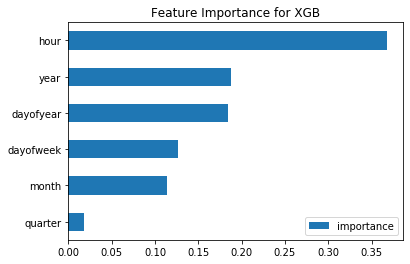

In [38]:
fi_xgb.sort_values('importance').plot(kind='barh',title='Feature Importance for XGB')

# Forecast on Test Set

In [39]:
test['XGB prediction']=model_xgb.predict(X_test)

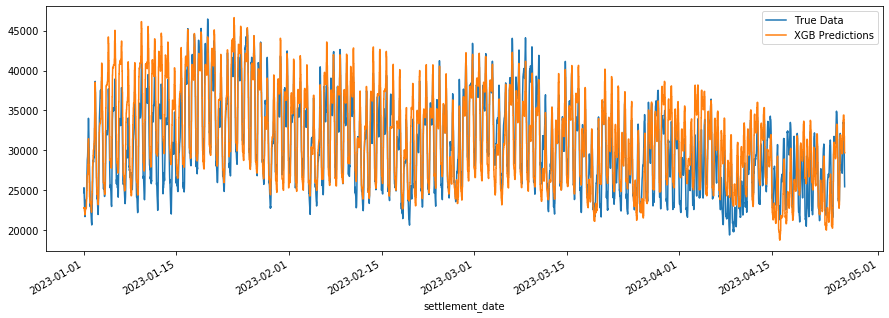

In [40]:
fig,ax = plt.subplots(figsize=(15,5))
test['tsd'].plot(ax=ax,label='True Data')
test['XGB prediction'].plot(ax=ax,label='XGB Predictions')
ax.legend(['True Data','XGB Predictions'])
plt.show()

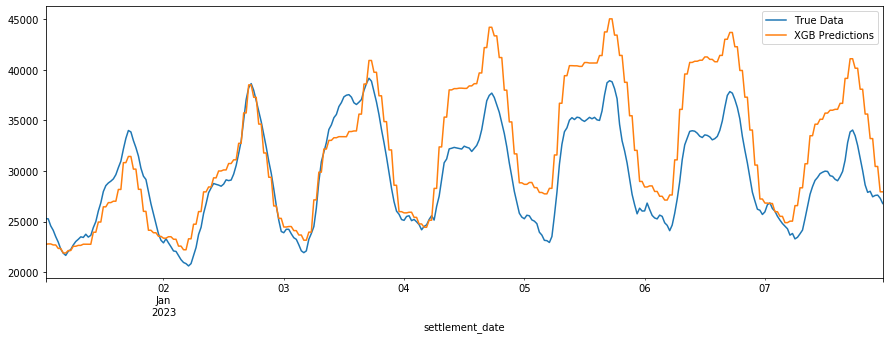

In [41]:
fig,ax = plt.subplots(figsize=(15,5))
test['tsd'].loc[(test.index>'01-01-2023') & (test.index < '01-08-2023')].plot(ax=ax,label='True Data')
test['XGB prediction'].loc[(test.index>'01-01-2023') & (test.index < '01-08-2023')].plot(ax=ax,label='XGB Predictions')
ax.legend(['True Data','XGB Predictions'])
plt.show()

In [42]:
score = np.sqrt(mean_squared_error(test['tsd'],test['XGB prediction']))
print(f'XGB model RMSE score on test set:{score:0.4}')

XGB model RMSE score on test set:2.998e+03


# LGB Model Creation

Let's now compare the performance of the XGB model against LGB.

In [43]:
model_lgb = lgb.LGBMRegressor(n_estimators=1000) 
model_lgb.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=True)

[1]	training's l2: 4.89325e+07	valid_1's l2: 3.41144e+07
[2]	training's l2: 4.17583e+07	valid_1's l2: 2.97786e+07
[3]	training's l2: 3.58898e+07	valid_1's l2: 2.67211e+07
[4]	training's l2: 3.10662e+07	valid_1's l2: 2.40439e+07
[5]	training's l2: 2.70738e+07	valid_1's l2: 2.17337e+07
[6]	training's l2: 2.37159e+07	valid_1's l2: 2.00632e+07
[7]	training's l2: 2.09084e+07	valid_1's l2: 1.85328e+07
[8]	training's l2: 1.85431e+07	valid_1's l2: 1.73591e+07
[9]	training's l2: 1.65655e+07	valid_1's l2: 1.61635e+07
[10]	training's l2: 1.49197e+07	valid_1's l2: 1.5359e+07
[11]	training's l2: 1.34873e+07	valid_1's l2: 1.47203e+07
[12]	training's l2: 1.22783e+07	valid_1's l2: 1.39092e+07
[13]	training's l2: 1.12372e+07	valid_1's l2: 1.33213e+07
[14]	training's l2: 1.03309e+07	valid_1's l2: 1.26992e+07
[15]	training's l2: 9.53165e+06	valid_1's l2: 1.21147e+07
[16]	training's l2: 8.82462e+06	valid_1's l2: 1.16844e+07
[17]	training's l2: 8.21896e+06	valid_1's l2: 1.11608e+07
[18]	training's l2: 7.70

[146]	training's l2: 2.2083e+06	valid_1's l2: 7.10964e+06
[147]	training's l2: 2.20535e+06	valid_1's l2: 7.10138e+06
[148]	training's l2: 2.20112e+06	valid_1's l2: 7.10312e+06
[149]	training's l2: 2.19822e+06	valid_1's l2: 7.10331e+06
[150]	training's l2: 2.19407e+06	valid_1's l2: 7.10262e+06
[151]	training's l2: 2.19016e+06	valid_1's l2: 7.08847e+06
[152]	training's l2: 2.18231e+06	valid_1's l2: 7.09179e+06
[153]	training's l2: 2.17625e+06	valid_1's l2: 7.11362e+06
[154]	training's l2: 2.16537e+06	valid_1's l2: 7.11235e+06
[155]	training's l2: 2.16115e+06	valid_1's l2: 7.11646e+06
[156]	training's l2: 2.14733e+06	valid_1's l2: 7.11612e+06
[157]	training's l2: 2.14499e+06	valid_1's l2: 7.11084e+06
[158]	training's l2: 2.14069e+06	valid_1's l2: 7.10809e+06
[159]	training's l2: 2.13281e+06	valid_1's l2: 7.10534e+06
[160]	training's l2: 2.12956e+06	valid_1's l2: 7.10886e+06
[161]	training's l2: 2.12311e+06	valid_1's l2: 7.09745e+06
[162]	training's l2: 2.11839e+06	valid_1's l2: 7.13119e+0

[291]	training's l2: 1.68959e+06	valid_1's l2: 7.10887e+06
[292]	training's l2: 1.68795e+06	valid_1's l2: 7.10894e+06
[293]	training's l2: 1.68423e+06	valid_1's l2: 7.10205e+06
[294]	training's l2: 1.6825e+06	valid_1's l2: 7.10225e+06
[295]	training's l2: 1.67785e+06	valid_1's l2: 7.09846e+06
[296]	training's l2: 1.67483e+06	valid_1's l2: 7.09266e+06
[297]	training's l2: 1.67401e+06	valid_1's l2: 7.0929e+06
[298]	training's l2: 1.66976e+06	valid_1's l2: 7.09201e+06
[299]	training's l2: 1.66701e+06	valid_1's l2: 7.09252e+06
[300]	training's l2: 1.66609e+06	valid_1's l2: 7.09276e+06
[301]	training's l2: 1.66126e+06	valid_1's l2: 7.08198e+06
[302]	training's l2: 1.65891e+06	valid_1's l2: 7.07671e+06
[303]	training's l2: 1.6575e+06	valid_1's l2: 7.07679e+06
[304]	training's l2: 1.65309e+06	valid_1's l2: 7.07628e+06
[305]	training's l2: 1.65178e+06	valid_1's l2: 7.07599e+06
[306]	training's l2: 1.64732e+06	valid_1's l2: 7.06718e+06
[307]	training's l2: 1.64672e+06	valid_1's l2: 7.06702e+06


[442]	training's l2: 1.42819e+06	valid_1's l2: 7.2786e+06
[443]	training's l2: 1.42673e+06	valid_1's l2: 7.28116e+06
[444]	training's l2: 1.42508e+06	valid_1's l2: 7.2787e+06
[445]	training's l2: 1.42397e+06	valid_1's l2: 7.27844e+06
[446]	training's l2: 1.42275e+06	valid_1's l2: 7.27838e+06
[447]	training's l2: 1.42142e+06	valid_1's l2: 7.27679e+06
[448]	training's l2: 1.42091e+06	valid_1's l2: 7.28184e+06
[449]	training's l2: 1.41949e+06	valid_1's l2: 7.28366e+06
[450]	training's l2: 1.41821e+06	valid_1's l2: 7.28585e+06
[451]	training's l2: 1.41364e+06	valid_1's l2: 7.31239e+06
[452]	training's l2: 1.41212e+06	valid_1's l2: 7.31198e+06
[453]	training's l2: 1.41074e+06	valid_1's l2: 7.31539e+06
[454]	training's l2: 1.41012e+06	valid_1's l2: 7.31101e+06
[455]	training's l2: 1.40777e+06	valid_1's l2: 7.31062e+06
[456]	training's l2: 1.40548e+06	valid_1's l2: 7.3208e+06
[457]	training's l2: 1.40447e+06	valid_1's l2: 7.34524e+06
[458]	training's l2: 1.40403e+06	valid_1's l2: 7.34526e+06


[596]	training's l2: 1.23676e+06	valid_1's l2: 7.47846e+06
[597]	training's l2: 1.23514e+06	valid_1's l2: 7.47882e+06
[598]	training's l2: 1.23445e+06	valid_1's l2: 7.49052e+06
[599]	training's l2: 1.23405e+06	valid_1's l2: 7.48938e+06
[600]	training's l2: 1.23308e+06	valid_1's l2: 7.48963e+06
[601]	training's l2: 1.23176e+06	valid_1's l2: 7.48911e+06
[602]	training's l2: 1.23089e+06	valid_1's l2: 7.48965e+06
[603]	training's l2: 1.23011e+06	valid_1's l2: 7.49003e+06
[604]	training's l2: 1.22938e+06	valid_1's l2: 7.48988e+06
[605]	training's l2: 1.2285e+06	valid_1's l2: 7.4904e+06
[606]	training's l2: 1.22701e+06	valid_1's l2: 7.49036e+06
[607]	training's l2: 1.22641e+06	valid_1's l2: 7.49056e+06
[608]	training's l2: 1.22585e+06	valid_1's l2: 7.49041e+06
[609]	training's l2: 1.22516e+06	valid_1's l2: 7.48988e+06
[610]	training's l2: 1.22431e+06	valid_1's l2: 7.49294e+06
[611]	training's l2: 1.22297e+06	valid_1's l2: 7.49329e+06
[612]	training's l2: 1.2213e+06	valid_1's l2: 7.49325e+06


[751]	training's l2: 1.11351e+06	valid_1's l2: 7.58616e+06
[752]	training's l2: 1.11231e+06	valid_1's l2: 7.58632e+06
[753]	training's l2: 1.11201e+06	valid_1's l2: 7.58641e+06
[754]	training's l2: 1.11128e+06	valid_1's l2: 7.58772e+06
[755]	training's l2: 1.1098e+06	valid_1's l2: 7.57881e+06
[756]	training's l2: 1.10863e+06	valid_1's l2: 7.57466e+06
[757]	training's l2: 1.10748e+06	valid_1's l2: 7.5735e+06
[758]	training's l2: 1.10731e+06	valid_1's l2: 7.57359e+06
[759]	training's l2: 1.10641e+06	valid_1's l2: 7.57387e+06
[760]	training's l2: 1.10546e+06	valid_1's l2: 7.5699e+06
[761]	training's l2: 1.10524e+06	valid_1's l2: 7.56998e+06
[762]	training's l2: 1.10478e+06	valid_1's l2: 7.56689e+06
[763]	training's l2: 1.10442e+06	valid_1's l2: 7.56701e+06
[764]	training's l2: 1.10314e+06	valid_1's l2: 7.56476e+06
[765]	training's l2: 1.10246e+06	valid_1's l2: 7.56496e+06
[766]	training's l2: 1.10228e+06	valid_1's l2: 7.56505e+06
[767]	training's l2: 1.10185e+06	valid_1's l2: 7.56503e+06


[900]	training's l2: 1.02399e+06	valid_1's l2: 7.69376e+06
[901]	training's l2: 1.02263e+06	valid_1's l2: 7.6912e+06
[902]	training's l2: 1.02222e+06	valid_1's l2: 7.69098e+06
[903]	training's l2: 1.0204e+06	valid_1's l2: 7.69129e+06
[904]	training's l2: 1.01993e+06	valid_1's l2: 7.69189e+06
[905]	training's l2: 1.01921e+06	valid_1's l2: 7.69172e+06
[906]	training's l2: 1.01819e+06	valid_1's l2: 7.69209e+06
[907]	training's l2: 1.01749e+06	valid_1's l2: 7.6908e+06
[908]	training's l2: 1.01581e+06	valid_1's l2: 7.69044e+06
[909]	training's l2: 1.01508e+06	valid_1's l2: 7.69024e+06
[910]	training's l2: 1.01419e+06	valid_1's l2: 7.69295e+06
[911]	training's l2: 1.01358e+06	valid_1's l2: 7.69276e+06
[912]	training's l2: 1.01306e+06	valid_1's l2: 7.70026e+06
[913]	training's l2: 1.01249e+06	valid_1's l2: 7.70015e+06
[914]	training's l2: 1.01189e+06	valid_1's l2: 7.69996e+06
[915]	training's l2: 1.01126e+06	valid_1's l2: 7.69849e+06
[916]	training's l2: 1.01068e+06	valid_1's l2: 7.69853e+06


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# Forecast on Test Set

In [44]:
test['LGB prediction']=model_lgb.predict(X_test)

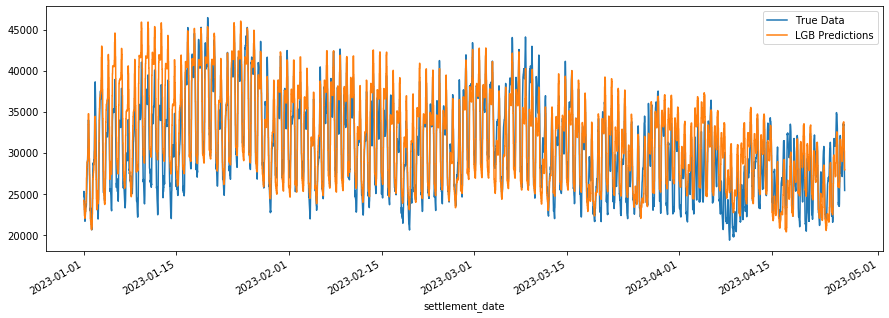

In [45]:
fig,ax = plt.subplots(figsize=(15,5))
test['tsd'].plot(ax=ax,label='True Data')
test['LGB prediction'].plot(ax=ax,label='LGB Predictions')
ax.legend(['True Data','LGB Predictions'])
plt.show()

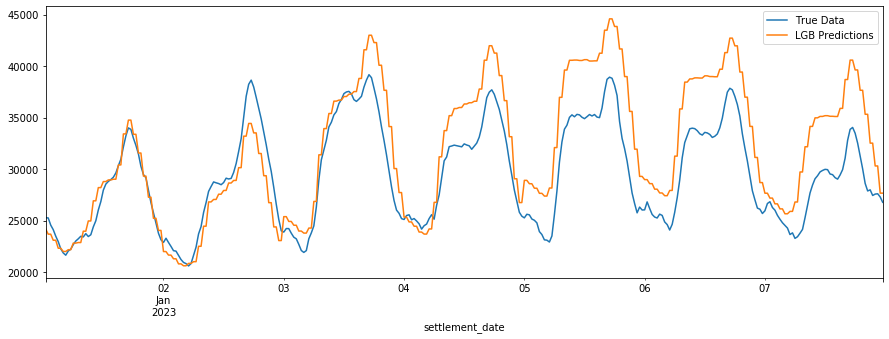

In [46]:
fig,ax = plt.subplots(figsize=(15,5))
test['tsd'].loc[(test.index>'01-01-2023') & (test.index < '01-08-2023')].plot(ax=ax,label='True Data')
test['LGB prediction'].loc[(test.index>'01-01-2023') & (test.index < '01-08-2023')].plot(ax=ax,label='LGB Predictions')
ax.legend(['True Data','LGB Predictions'])
plt.show()

In [47]:
score = np.sqrt(mean_squared_error(test['tsd'],test['LGB prediction']))
print(f'LGB model RMSE score on test set:{score:0.4}')

LGB model RMSE score on test set:2.781e+03


Let's bring both models together by comparing each model's predictions 

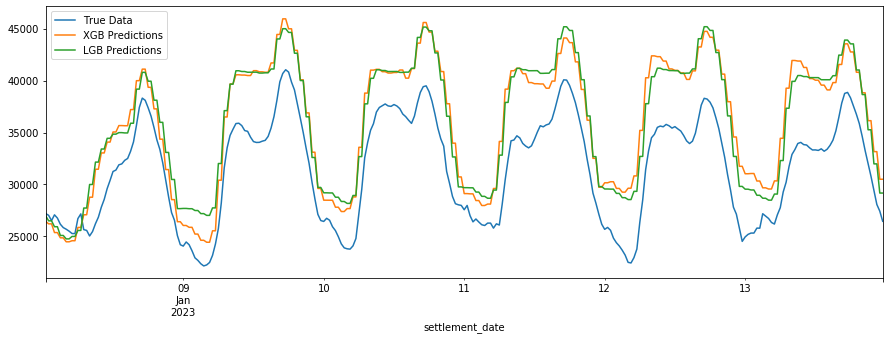

In [35]:
fig,ax = plt.subplots(figsize=(15,5))
time_span = (test.index>'01-08-2023') & (test.index < '01-14-2023')
test['tsd'].loc[time_span].plot(ax=ax,label='True Data')
test['XGB prediction'].loc[time_span].plot(ax=ax,label='XGB Predictions')
test['LGB prediction'].loc[time_span].plot(ax=ax,label='LGB Predictions')
ax.legend(['True Data','XGB Predictions','LGB Predictions'])
plt.show()